# **Homework BPMDD**
**by Silvia Moro (2089329), Emma Roveroni (2058618)**

**Univerisity of Padova, 2023**

In [143]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [144]:
import pandas as pd 
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import zscore
from sklearn.linear_model import LassoCV
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
from scipy.stats import fisher_exact
from scipy.stats import kruskal
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Load the data

In [145]:
xls = pd.ExcelFile(r'Homework_Dataset.xlsx')
radiomics = pd.read_excel(xls, 'Radiomics')
demographics_clinical = pd.read_excel(xls, 'Demographics Clinical')
clinical = pd.read_excel(xls, 'CLINICAL')

In [146]:
radiomics_clinical  = pd.merge(radiomics, clinical, on='id_subject', how='inner')

Visualize first 5 rows for each dataset

In [147]:
radiomics.head()

,id_subject,loc_peak_loc,loc_peak_glob,stat_mean,stat_var,stat_skew,stat_kurt,stat_median,stat_min,stat_p10,...,ngl_hdhge_d1_a0.0_3d_fbs_w0.0125,ngl_glnu_d1_a0.0_3d_fbs_w0.0125,ngl_glnu_norm_d1_a0.0_3d_fbs_w0.0125,ngl_dcnu_d1_a0.0_3d_fbs_w0.0125,ngl_dcnu_norm_d1_a0.0_3d_fbs_w0.0125,ngl_dc_perc_d1_a0.0_3d_fbs_w0.0125,ngl_gl_var_d1_a0.0_3d_fbs_w0.0125,ngl_dc_var_d1_a0.0_3d_fbs_w0.0125,ngl_dc_entr_d1_a0.0_3d_fbs_w0.0125,ngl_dc_energy_d1_a0.0_3d_fbs_w0.0125
0,ID_1,4.367148,4.378462,2.228290,0.667989,1.530631,1.511877,1.908921,1.500030,1.561387,...,14585.164244,30.287064,0.011005,1104.584302,0.401375,1,4274.447885,1.368704,8.429116,0.003936
1,ID_2,3.779030,3.803949,2.187555,0.384019,1.326379,1.168714,1.986067,1.500117,1.594954,...,11362.955467,20.953263,0.009239,1119.872134,0.493771,1,2456.642411,0.522943,8.141883,0.004538
2,ID_3,3.233660,3.233798,2.276786,0.359799,0.538311,-0.959822,2.123215,1.500243,1.591756,...,15962.161734,15.005285,0.007931,1018.762156,0.538458,1,2301.951850,0.413739,8.058827,0.004580
3,ID_4,5.084474,5.290133,2.677889,0.565180,1.113553,1.230447,2.510247,1.500425,1.856742,...,25117.256649,17.194819,0.005939,1527.539551,0.527648,1,3617.937748,0.446256,8.603763,0.003210
4,ID_5,4.535594,4.535594,2.165708,0.586335,1.631404,2.061551,1.837124,1.500109,1.555559,...,12542.362012,29.666667,0.012330,892.307564,0.370868,1,3753.531084,1.305924,8.368670,0.004104


In [148]:
demographics_clinical.head()

,id_subject,"Group (1=PD, 0 = Controls)",Age,"Gender (M=0, F=1)",Education (Years),Height,Weight,BMI
0,ID_1,1,48,0,14,170.0,62.6,21.660900
1,ID_2,1,67,1,20,176.0,74.4,24.018595
2,ID_3,1,51,0,18,168.0,89.3,31.639739
3,ID_4,1,63,1,11,169.0,83.1,29.095620
4,ID_5,1,59,0,18,181.0,84.3,25.731815


In [149]:
clinical.head()

,id_subject,LEDD Total,UPDRS I,UPDRS II,UPDRS III,UPDRS IV,UPDRS total,NMSQ,MMSE,MoCA
0,ID_1,560.0,16,20,55,8,99,12,29,25
1,ID_2,500.0,5,5,23,0,33,1,30,25
2,ID_3,1102.5,21,18,47,8,94,13,28,25
3,ID_4,580.0,8,3,24,0,35,2,30,29
4,ID_5,500.0,8,8,27,0,43,6,30,28


Check for Nan value in the dataset 

In [150]:
print(radiomics.isnull().values.any())

False


Remove feature *ngl_dc_perc_d1_a0.0_3d_fbs_w0.0125* since all its values are equal to 1, and *id_subject*

In [151]:
radiomics = radiomics.drop(['ngl_dc_perc_d1_a0.0_3d_fbs_w0.0125'], axis=1)
radiomics = radiomics.drop(['id_subject'], axis=1)

In [152]:
target = [1] * 33 + [0] * 20 #  1 for PD patients, 0 for HC.

In [153]:
radiomics['target'] = target

## LASSO selcted features

In [154]:
X = radiomics.iloc[:,0:-1]
y = radiomics.iloc[:,-1]
X = X.apply(zscore)

In [155]:
lasso_cv = LassoCV(cv=10, max_iter = 100000) 
lasso_cv.fit(X, y)

optimal_alpha = lasso_cv.alpha_

coeff = lasso_cv.coef_

selected_features = X.columns[coeff !=0] 

index_selected_features = np.where(lasso_cv.coef_!= 0)[0]

print(f"Best alpha is : {optimal_alpha}")
print(selected_features)

Best alpha is : 0.00898604464172778
Index(['stat_qcod', 'ivh_v50', 'ivh_diff_v25_v75', 'ivh_diff_i25_i75',
       'morph_comp_2', 'morph_com', 'morph_pca_maj_axis',
       'morph_pca_elongation', 'morph_area_dens_aee',
       'morph_area_dens_conv_hull', 'morph_moran_i', 'ih_min_fbs_w0.0125',
       'ih_iqr_fbs_w0.0125', 'ih_max_grad_g_fbs_w0.0125',
       'cm_clust_shade_d1_3d_avg_fbs_w0.0125',
       'cm_info_corr2_d1_3d_avg_fbs_w0.0125', 'szm_lzlge_3d_fbs_w0.0125',
       'dzm_sdlge_3d_fbs_w0.0125', 'ngl_hdlge_d1_a0.0_3d_fbs_w0.0125'],
      dtype='object')


In [157]:
index_selected_features = np.append(index_selected_features, len(radiomics.columns)-1)
radiomics = radiomics.iloc[:, index_selected_features]
radiomics.head()

,stat_qcod,ivh_v50,ivh_diff_v25_v75,ivh_diff_i25_i75,morph_comp_2,morph_com,morph_pca_maj_axis,morph_pca_elongation,morph_area_dens_aee,morph_area_dens_conv_hull,morph_moran_i,ih_min_fbs_w0.0125,ih_iqr_fbs_w0.0125,ih_max_grad_g_fbs_w0.0125,cm_clust_shade_d1_3d_avg_fbs_w0.0125,cm_info_corr2_d1_3d_avg_fbs_w0.0125,szm_lzlge_3d_fbs_w0.0125,dzm_sdlge_3d_fbs_w0.0125,ngl_hdlge_d1_a0.0_3d_fbs_w0.0125,target
0,0.202163,0.133721,0.223474,0.8250,0.205569,4.323554,111.083030,0.417252,0.784980,0.698906,0.215071,1,66.0,5,3.125000e+06,0.999263,0.175093,0.015500,0.180463,1
1,0.171895,0.135362,0.297619,0.7250,0.191965,4.585673,101.450752,0.423847,0.860326,0.730522,0.169781,1,58.0,9,1.084699e+06,0.998926,0.045008,0.009375,0.070901,1
2,0.223752,0.287526,0.420719,1.0000,0.162617,3.836548,98.767533,0.401691,0.917724,0.700025,0.160456,1,80.0,54,3.610128e+05,0.999292,0.055476,0.009355,0.072449,1
3,0.169249,0.116408,0.451468,0.8750,0.216929,0.899736,99.937219,0.420002,0.828375,0.705431,0.127529,1,70.0,49,1.567183e+06,0.999545,0.005669,0.002144,0.007283,1
4,0.198106,0.098088,0.225686,0.8125,0.183168,4.282801,99.824982,0.452044,0.840619,0.730077,0.209050,1,64.5,9,2.742136e+06,0.999171,0.241054,0.019852,0.262047,1


# Demographics statistic 

Separate HC from PD

In [158]:
radiomics_PD = radiomics.iloc[0:33]
radiomics_HC = radiomics.iloc[33:]
radiomics_PD = radiomics_PD.drop(['target'], axis=1)
radiomics_HC = radiomics_HC.drop(['target'], axis=1)

In [159]:
demographics_clinical_PD = demographics_clinical.iloc[0:33]
demographics_clinical_HC = demographics_clinical.iloc[33:]
demographics_clinical_PD = demographics_clinical_PD.drop(['Group (1=PD, 0 = Controls)', 'id_subject'], axis=1)
demographics_clinical_HC = demographics_clinical_HC.drop(['Group (1=PD, 0 = Controls)', 'id_subject'], axis=1)

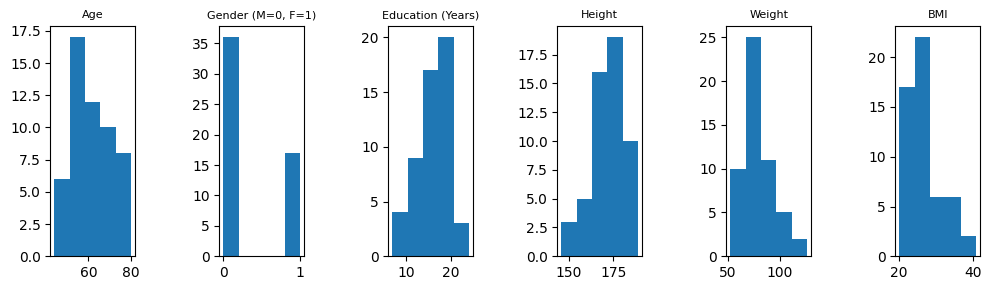

In [160]:
demographics_clinical = demographics_clinical.drop(['Group (1=PD, 0 = Controls)', 'id_subject'], axis=1)

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(10, 3))

for i, col in enumerate(demographics_clinical.columns):
    ax = axs[i] 
    ax.hist(demographics_clinical[col], bins=5)  
    ax.set_title(col, fontsize=8)          

for i in range(len(demographics_clinical.columns), 1*6):
    axs[i].axis('off')  

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=1)

plt.show()


In [161]:
gender_PD = list(demographics_clinical_PD['Gender (M=0, F=1)'])
gender_HC = list(demographics_clinical_HC['Gender (M=0, F=1)'])

demographics_clinical_PD = demographics_clinical_PD.drop(['Gender (M=0, F=1)'], axis = 1)
demographics_clinical_HC = demographics_clinical_HC.drop(['Gender (M=0, F=1)'], axis = 1)

demo_mean_PD = demographics_clinical_PD.mean()
demo_mean_HC = demographics_clinical_HC.mean()
demo_sd_PD = demographics_clinical_PD.std()
demo_sd_HC = demographics_clinical_HC.std()

demo_features = ['Age', 'Education (Years)', 'Height', 'Weight', 'BMI']

demo_col_names = ['Features', 'Mean PD', 'Mean HC', 'Standard deviation PD', 'Standard deviation HC']
demo_temp = list(zip(demo_features, demo_mean_PD, demo_mean_HC , demo_sd_PD, demo_sd_HC))

demo_comparison_df = pd.DataFrame(demo_temp, columns = demo_col_names)
demo_comparison_df

,Features,Mean PD,Mean HC,Standard deviation PD,Standard deviation HC
0,Age,60.545455,63.100000,9.520015,8.589467
1,Education (Years),15.787879,16.550000,3.586063,3.440854
2,Height,169.987879,173.520000,10.076481,8.566803
3,Weight,78.066667,81.435000,16.325396,12.046632
4,BMI,26.980015,27.119627,4.989650,4.141265


In [162]:
gender_PD_0 = gender_PD.count(0)
gender_PD_1 = gender_PD.count(1)
gender_HC_0 = gender_HC.count(0)
gender_HC_1 = gender_HC.count(1)
gender_table = [[gender_PD_0,gender_PD_1],[gender_HC_0,gender_HC_1]]
gender_col = ['Male', 'Female']

gender = pd.DataFrame(gender_table, columns=gender_col)
gender

,Male,Female
0,21,12
1,15,5


In [163]:
stat = []
p_val = []

for i in demographics_clinical_PD.columns:
  s, p = mannwhitneyu(demographics_clinical_PD[i], demographics_clinical_HC[i])
  stat.append(s)
  p_val.append(p)

In [164]:
t = list(zip(demographics_clinical_PD.columns, stat,p_val))

res = pd.DataFrame(t, columns = ['Features','Statistic', 'p_values'])
res

,Features,Statistic,p_values
0,Age,281.0,0.373022
1,Education (Years),303.5,0.628683
2,Height,256.5,0.180054
3,Weight,271.5,0.287189
4,BMI,302.0,0.613834


In [166]:
odds_ratio, p_value_fisher = fisher_exact(gender)
print(odds_ratio, p_value_fisher)

0.5833333333333334 0.5457329620924248


## Correlation between radiomics and covariates

In [239]:
correlations = []
p_values = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics[feature], demographics_clinical['Age'])
    correlations.append(corr)
    p_values.append(p_value)

temp = list(zip(radiomics_PD.columns, correlations, p_values))

age_results = pd.DataFrame(temp, columns = ['features','Correlation', 'p_values'])

In [240]:


correlations = []
p_values = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics[feature], demographics_clinical['BMI'])
    correlations.append(corr)
    p_values.append(p_value)

temp = list(zip(radiomics_PD.columns, correlations, p_values))

BMI_results = pd.DataFrame(temp, columns = ['features','Correlation', 'p_values'])

In [241]:
correlations = []
p_values = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics[feature], demographics_clinical['Education (Years)'])
    correlations.append(corr)
    p_values.append(p_value)

temp = list(zip(radiomics_PD.columns, correlations, p_values))

education_results = pd.DataFrame(temp, columns = ['features','Correlation', 'p_values'])

In [242]:
correlations = []
p_values = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics[feature], demographics_clinical['Height'])
    correlations.append(corr)
    p_values.append(p_value)

temp = list(zip(radiomics_PD.columns, correlations, p_values))

height_results = pd.DataFrame(temp, columns = ['features','Correlation', 'p_values'])

In [243]:
correlations = []
p_values = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics[feature], demographics_clinical['Weight'])
    correlations.append(corr)
    p_values.append(p_value)

temp = list(zip(radiomics_PD.columns, correlations, p_values))

weight_results = pd.DataFrame(temp, columns = ['features','Correlation', 'p_values'])

# Preliminary analysis of the features 

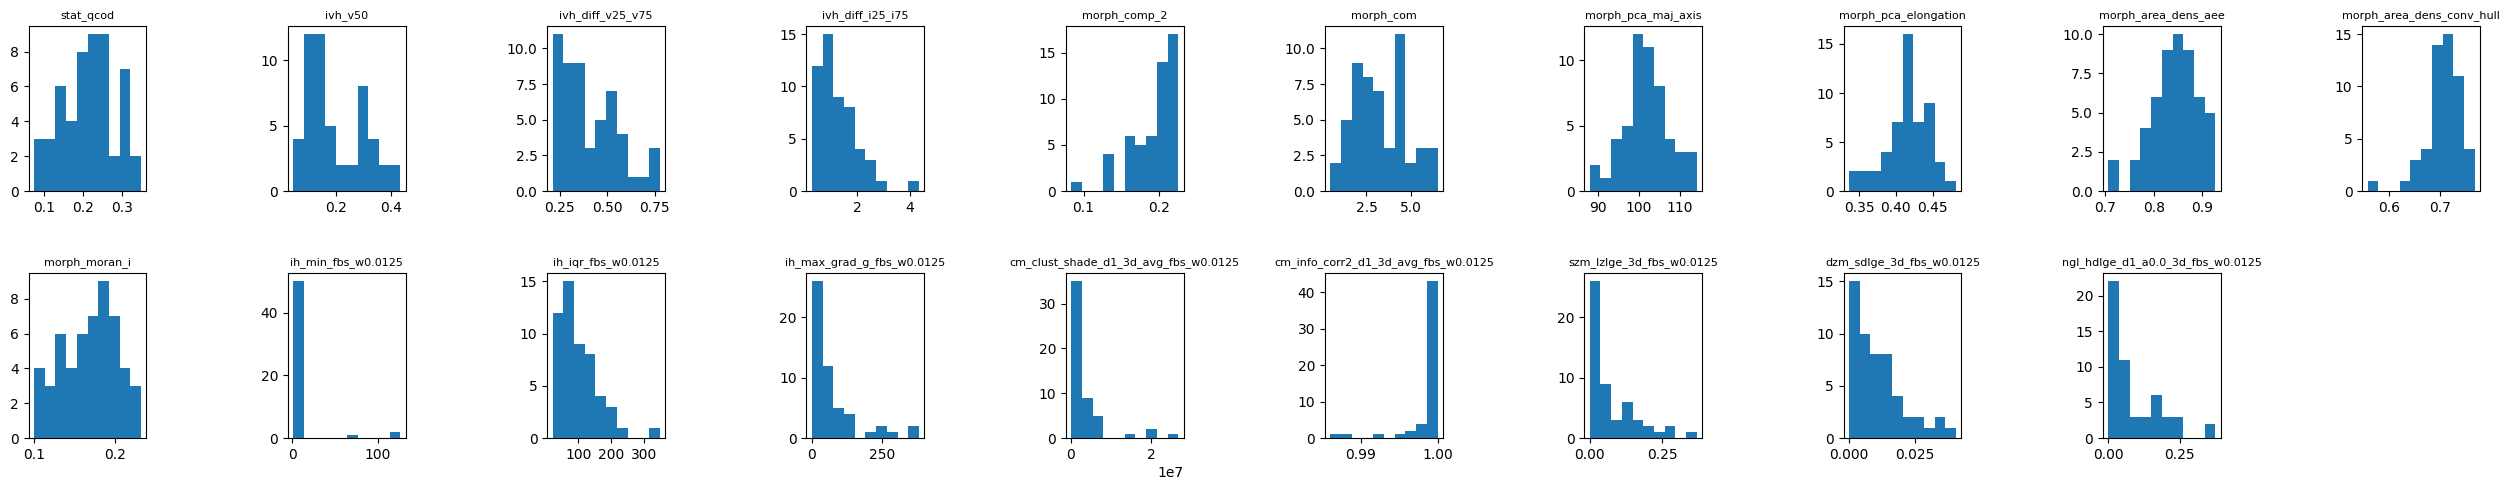

In [172]:
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(25, 5))

for i, col in enumerate(radiomics_PD.columns):
    ax = axs[i // 10][i % 10]  
    ax.hist(radiomics[col], bins=10)  
    ax.set_title(col, fontsize = 8)          

for i in range(len(radiomics.columns[:-1]), 2*10):
    axs[i // 10][i % 10].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=1.2)

plt.show()


# GROUP DIFFERENCES

# Is there any difference between HCs and PD in radiomics features (or combined score)?

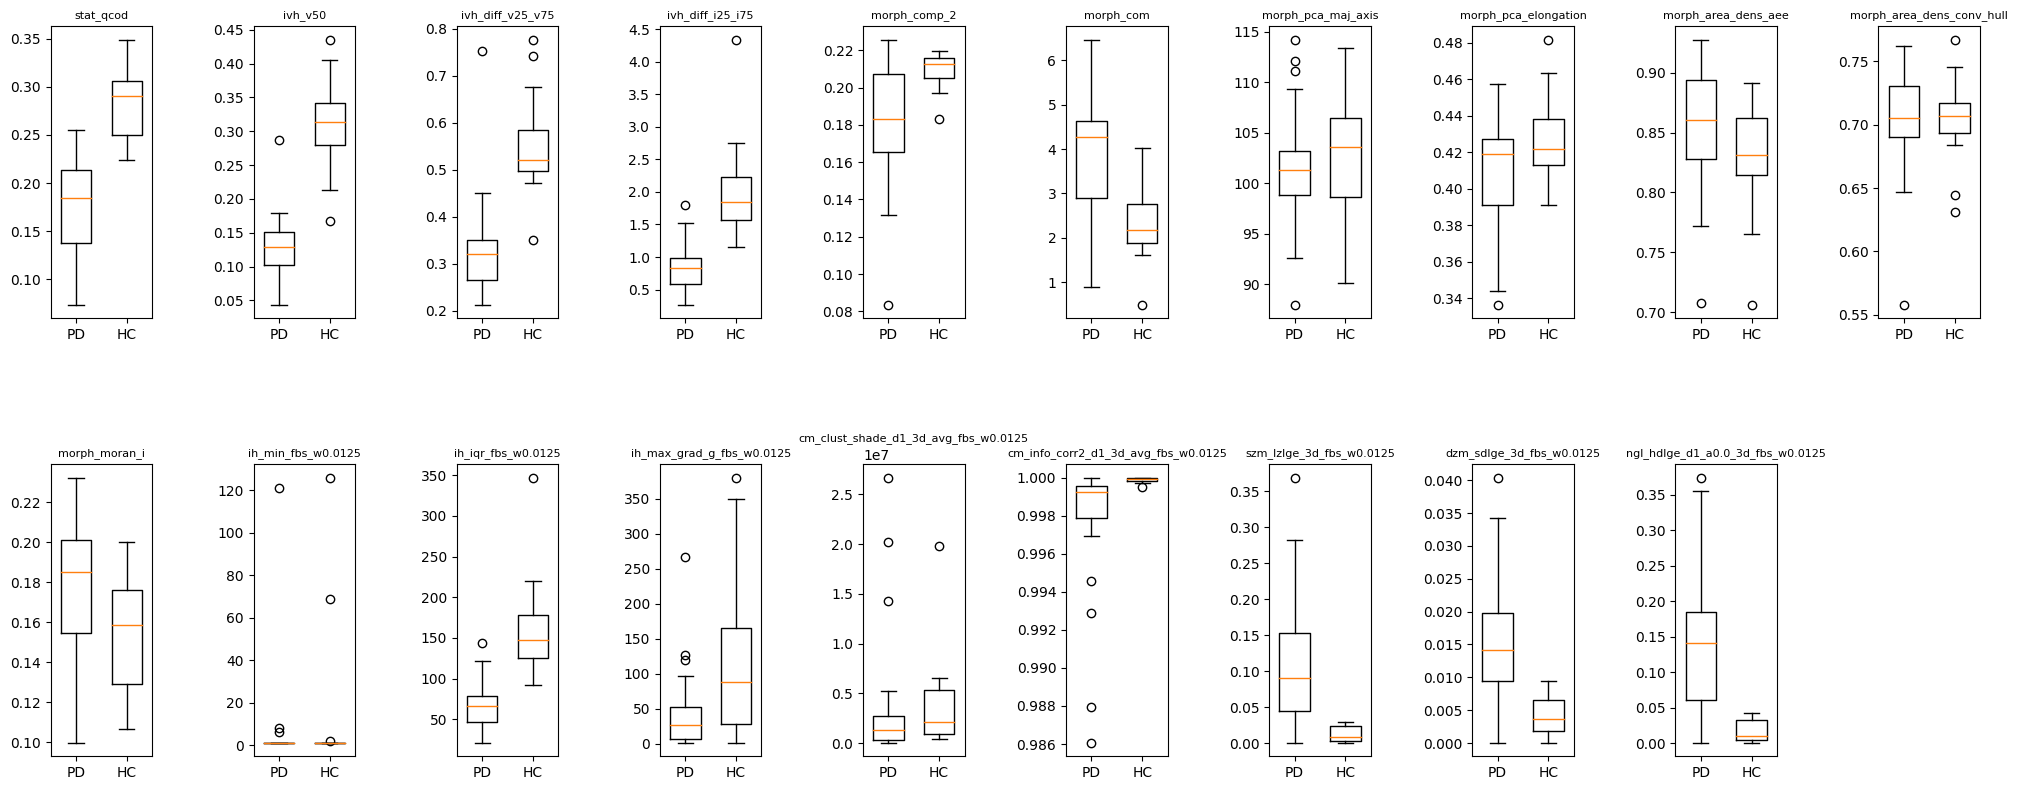

In [186]:
fig, axs = plt.subplots(nrows=2, ncols=10, figsize=(20, 8))

for i, col in enumerate(radiomics_HC.columns):
    ax = axs[i // 10][i % 10]  
    ax.boxplot(radiomics_PD[col], positions=[1], widths=0.6)
    ax.boxplot(radiomics_HC[col], positions=[2], widths=0.6)
    ax.set_xticklabels(['PD', 'HC'])
    ax.set_title(col, fontsize = 8)          

for i in range(len(radiomics_HC.columns), 2*10):
    axs[i // 10][i % 10].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=1)

plt.show()

Mann Whitney U test

In [180]:
U1 = [] #PD
U2 = [] #HC
p_values_m = []

for i in radiomics_PD.columns:
  U1_temp, p = mannwhitneyu(radiomics_PD[i], radiomics_HC[i], method="auto")
  U1.append(U1_temp)
  p_values_m.append(p)
  U2_temp = len(radiomics_PD[i])*len(radiomics_HC[i]) - U1_temp
  U2.append(U2_temp)

In [181]:
temp2 = list(zip(radiomics_PD.columns, U1,U2,p_values_m))

mannwhitneyu_results = pd.DataFrame(temp2, columns = ['features','U1', 'U2', 'p_values'])
mannwhitneyu_results

,features,U1,U2,p_values
0,stat_qcod,22.0,638.0,1.676577e-08
1,ivh_v50,8.0,652.0,3.649787e-09
2,ivh_diff_v25_v75,26.0,634.0,2.561442e-08
3,ivh_diff_i25_i75,19.5,640.5,1.279565e-08
4,morph_comp_2,132.0,528.0,2.900752e-04
5,morph_com,550.0,110.0,5.632696e-05
6,morph_pca_maj_axis,277.0,383.0,3.353753e-01
7,morph_pca_elongation,254.0,406.0,1.659365e-01
8,morph_area_dens_aee,434.0,226.0,5.754311e-02
9,morph_area_dens_conv_hull,341.0,319.0,8.472185e-01


In [182]:
mannwhitneyu_results = mannwhitneyu_results[mannwhitneyu_results['p_values'] < 0.05]
mannwhitneyu_results

,features,U1,U2,p_values
0,stat_qcod,22.0,638.0,1.676577e-08
1,ivh_v50,8.0,652.0,3.649787e-09
2,ivh_diff_v25_v75,26.0,634.0,2.561442e-08
3,ivh_diff_i25_i75,19.5,640.5,1.279565e-08
4,morph_comp_2,132.0,528.0,2.900752e-04
5,morph_com,550.0,110.0,5.632696e-05
10,morph_moran_i,465.0,195.0,1.358727e-02
12,ih_iqr_fbs_w0.0125,19.5,640.5,1.276990e-08
13,ih_max_grad_g_fbs_w0.0125,195.5,464.5,1.389526e-02
14,cm_clust_shade_d1_3d_avg_fbs_w0.0125,221.0,439.0,4.649084e-02


Kruskal-Wallis test

In [183]:
stat = []
p_values_k = []

for i in radiomics_PD.columns:
  s, p = kruskal(radiomics_PD[i], radiomics_HC[i])
  stat.append(s)
  p_values_k.append(p)

In [184]:
temp3 = list(zip(radiomics_PD.columns, stat, p_values_k))

kruskal_results = pd.DataFrame(temp3, columns = ['features','Statistic', 'p_values'])
kruskal_results

,features,Statistic,p_values
0,stat_qcod,31.940741,1.589482e-08
1,ivh_v50,34.910438,3.452252e-09
2,ivh_diff_v25_v75,31.116498,2.429972e-08
3,ivh_diff_i25_i75,32.466599,1.212588e-08
4,morph_comp_2,13.200000,2.799491e-04
5,morph_com,16.296296,5.416973e-05
6,morph_pca_maj_axis,0.945791,3.307929e-01
7,morph_pca_elongation,1.944781,1.631503e-01
8,morph_area_dens_aee,3.641751,5.634765e-02
9,morph_area_dens_conv_hull,0.040741,8.400392e-01


In [185]:
kruskal_results = kruskal_results[kruskal_results['p_values'] < 0.05]
kruskal_results

,features,Statistic,p_values
0,stat_qcod,31.940741,1.589482e-08
1,ivh_v50,34.910438,3.452252e-09
2,ivh_diff_v25_v75,31.116498,2.429972e-08
3,ivh_diff_i25_i75,32.466599,1.212588e-08
4,morph_comp_2,13.200000,2.799491e-04
5,morph_com,16.296296,5.416973e-05
10,morph_moran_i,6.136364,1.324294e-02
12,ih_iqr_fbs_w0.0125,32.470527,1.210139e-08
13,ih_max_grad_g_fbs_w0.0125,6.096647,1.354387e-02
14,cm_clust_shade_d1_3d_avg_fbs_w0.0125,4.000337,4.549118e-02


# Are the radiomic features or any derived scores associated to PD clinical symptoms severity? 

Correlation between radiomics features of PD patients and their score in clinical tests.

In [187]:
correlations_UPDRSI = []
p_values_UPDRSI = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics_PD[feature], clinical['UPDRS I'])
    correlations_UPDRSI.append(corr)
    p_values_UPDRSI.append(p_value)

temp5 = list(zip(radiomics_PD.columns, correlations_UPDRSI, p_values_UPDRSI))

UPDRSI_results = pd.DataFrame(temp5, columns = ['features','Correlation', 'p_values'])
UPDRSI_results

,features,Correlation,p_values
0,stat_qcod,0.086738,0.631250
1,ivh_v50,0.274811,0.121677
2,ivh_diff_v25_v75,0.135896,0.450808
3,ivh_diff_i25_i75,0.166626,0.354037
4,morph_comp_2,-0.107710,0.550755
5,morph_com,-0.045970,0.799474
6,morph_pca_maj_axis,0.060901,0.736362
7,morph_pca_elongation,0.011409,0.949757
8,morph_area_dens_aee,-0.143781,0.424713
9,morph_area_dens_conv_hull,-0.205353,0.251609


In [188]:
UPDRSI_results = UPDRSI_results[(UPDRSI_results['p_values'] < 0.05)]
UPDRSI_results

,features,Correlation,p_values


UPDRS II

In [189]:
correlations_UPDRSII = []
p_values_UPDRSII = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics_PD[feature], clinical['UPDRS II'])
    correlations_UPDRSII.append(corr)
    p_values_UPDRSII.append(p_value)

temp6 = list(zip(radiomics_PD.columns, correlations_UPDRSII, p_values_UPDRSII))

UPDRSII_results = pd.DataFrame(temp6, columns = ['features','Correlation', 'p_values'])
UPDRSII_results

,features,Correlation,p_values
0,stat_qcod,-0.206111,0.249825
1,ivh_v50,0.140485,0.435518
2,ivh_diff_v25_v75,0.072173,0.689794
3,ivh_diff_i25_i75,-0.154777,0.389765
4,morph_comp_2,-0.345925,0.048619
5,morph_com,0.087111,0.629781
6,morph_pca_maj_axis,0.176067,0.327029
7,morph_pca_elongation,-0.154751,0.389845
8,morph_area_dens_aee,-0.158612,0.377981
9,morph_area_dens_conv_hull,-0.399467,0.021273


In [190]:
UPDRSII_results2 = UPDRSII_results[UPDRSII_results['p_values'] < 0.05]
UPDRSII_results2

,features,Correlation,p_values
4,morph_comp_2,-0.345925,0.048619
9,morph_area_dens_conv_hull,-0.399467,0.021273


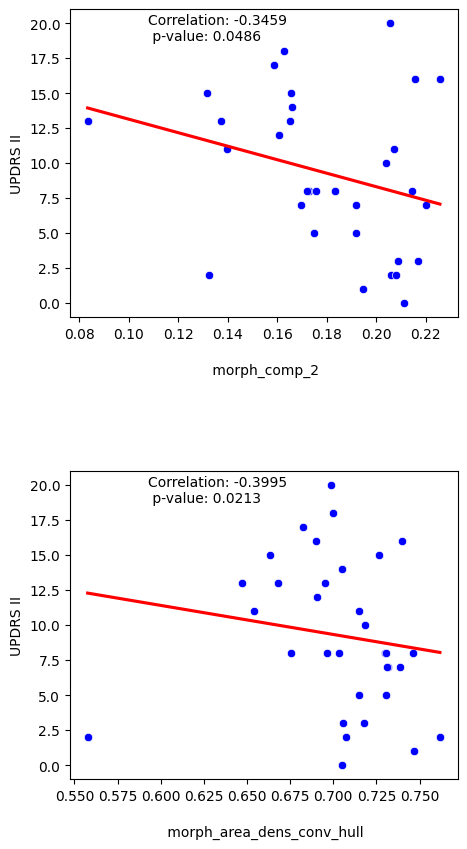

In [191]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

for i, col in enumerate(UPDRSII_results2['features']):
    ax = axs[i]  
    sns.scatterplot(x=radiomics_PD[col], y=clinical['UPDRS II'], color='b', ax=ax)
    sns.regplot(x=radiomics_PD[col], y=clinical['UPDRS II'], color='r', scatter=False, ax=ax, ci=None)
    corr = '{:.4f}'.format(float(UPDRSII_results2[UPDRSII_results2['features'] == col]['Correlation']))
    pv =  '{:.4f}'.format(float(UPDRSII_results2[UPDRSII_results2['features'] == col]['p_values']))
    ax.annotate( f"Correlation: {corr} \n p-value: {pv}", xy=(0.2, 0.9), xycoords='axes fraction')
    ax.set_xlabel(f'\n {col}')
    ax.set_ylabel('UPDRS II')       

for i in range(len(radiomics_HC.columns), 1*2):
    axs[i // 2][i % 2].axis('off')

plt.subplots_adjust(hspace=0.5, wspace=1)

plt.show()


UPDRS III

In [192]:
correlations_UPDRSIII = []
p_values_UPDRSIII = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics_PD[feature], clinical['UPDRS III'])
    correlations_UPDRSIII.append(corr)
    p_values_UPDRSIII.append(p_value)

temp7 = list(zip(radiomics_PD.columns, correlations_UPDRSIII, p_values_UPDRSIII))

UPDRSIII_results = pd.DataFrame(temp7, columns = ['features','Correlation', 'p_values'])
UPDRSIII_results

,features,Correlation,p_values
0,stat_qcod,-0.431324,0.012205
1,ivh_v50,-0.191290,0.286245
2,ivh_diff_v25_v75,-0.001508,0.993357
3,ivh_diff_i25_i75,-0.321746,0.067862
4,morph_comp_2,-0.369348,0.034398
5,morph_com,0.039029,0.829269
6,morph_pca_maj_axis,0.342882,0.050768
7,morph_pca_elongation,-0.416249,0.015976
8,morph_area_dens_aee,-0.259130,0.145338
9,morph_area_dens_conv_hull,-0.532832,0.001411


In [193]:
UPDRSIII_results2 = UPDRSIII_results[UPDRSIII_results['p_values'] < 0.05]
UPDRSIII_results2

,features,Correlation,p_values
0,stat_qcod,-0.431324,0.012205
4,morph_comp_2,-0.369348,0.034398
7,morph_pca_elongation,-0.416249,0.015976
9,morph_area_dens_conv_hull,-0.532832,0.001411
14,cm_clust_shade_d1_3d_avg_fbs_w0.0125,-0.349247,0.046355


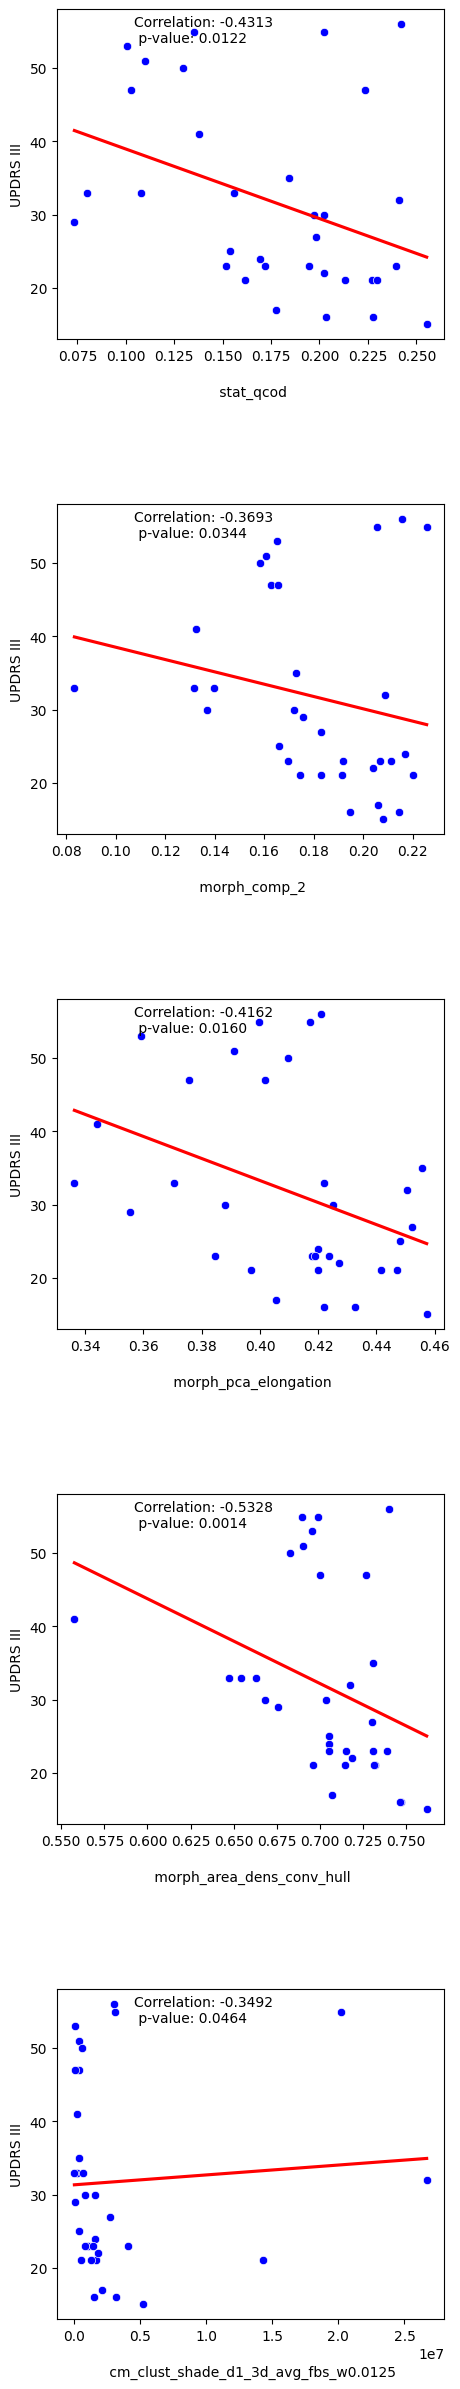

In [194]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(5, 30))

for i, col in enumerate(UPDRSIII_results2['features']):
    ax = axs[i]  
    sns.scatterplot(x=radiomics_PD[col], y=clinical['UPDRS III'], color='b', ax=ax)
    sns.regplot(x=radiomics_PD[col], y=clinical['UPDRS III'], color='r', scatter=False, ax=ax, ci=None)
    corr = '{:.4f}'.format(float(UPDRSIII_results[UPDRSIII_results['features'] == col]['Correlation']))
    pv =  '{:.4f}'.format(float(UPDRSIII_results[UPDRSIII_results['features'] == col]['p_values']))
    ax.annotate( f"Correlation: {corr} \n p-value: {pv}", xy=(0.2, 0.9), xycoords='axes fraction')
    ax.set_xlabel(f'\n {col}')
    ax.set_ylabel('UPDRS III')       

for i in range(len(radiomics_HC.columns), 1*5):
    axs[i // 5][i % 5].axis('off')

plt.subplots_adjust(hspace=0.5, wspace=1)

plt.show()


UPDRS IV

In [195]:
correlations_UPDRSIV = []
p_values_UPDRSIV = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics_PD[feature], clinical['UPDRS IV'])
    correlations_UPDRSIV.append(corr)
    p_values_UPDRSIV.append(p_value)

temp8 = list(zip(radiomics_PD.columns, correlations_UPDRSIV, p_values_UPDRSIV))

UPDRSIV_results = pd.DataFrame(temp8, columns = ['features','Correlation', 'p_values'])
UPDRSIV_results

,features,Correlation,p_values
0,stat_qcod,-0.080408,0.656451
1,ivh_v50,0.038194,0.832869
2,ivh_diff_v25_v75,0.273752,0.123179
3,ivh_diff_i25_i75,0.048344,0.789343
4,morph_comp_2,-0.008406,0.962968
5,morph_com,-0.105078,0.560587
6,morph_pca_maj_axis,-0.042397,0.814779
7,morph_pca_elongation,-0.015716,0.930826
8,morph_area_dens_aee,0.144917,0.421024
9,morph_area_dens_conv_hull,0.039656,0.826567


In [196]:
UPDRSIV_results = UPDRSIV_results[UPDRSIV_results['p_values'] < 0.05]
UPDRSIV_results

,features,Correlation,p_values


UPDRS total

In [197]:
correlations_UPDRStot = []
p_values_UPDRStot = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics_PD[feature], clinical['UPDRS total'])
    correlations_UPDRStot.append(corr)
    p_values_UPDRStot.append(p_value)

temp9 = list(zip(radiomics_PD.columns, correlations_UPDRStot, p_values_UPDRStot))

UPDRStot_results = pd.DataFrame(temp9, columns = ['features','Correlation', 'p_values'])
UPDRStot_results

,features,Correlation,p_values
0,stat_qcod,-0.327672,0.062671
1,ivh_v50,-0.024098,0.894101
2,ivh_diff_v25_v75,0.100075,0.579499
3,ivh_diff_i25_i75,-0.227885,0.202137
4,morph_comp_2,-0.412016,0.017195
5,morph_com,0.058405,0.746808
6,morph_pca_maj_axis,0.270438,0.127967
7,morph_pca_elongation,-0.311104,0.078023
8,morph_area_dens_aee,-0.203665,0.255613
9,morph_area_dens_conv_hull,-0.474438,0.005278


In [198]:
UPDRStot_results2 = UPDRStot_results[UPDRStot_results['p_values'] < 0.05]
UPDRStot_results2

,features,Correlation,p_values
4,morph_comp_2,-0.412016,0.017195
9,morph_area_dens_conv_hull,-0.474438,0.005278


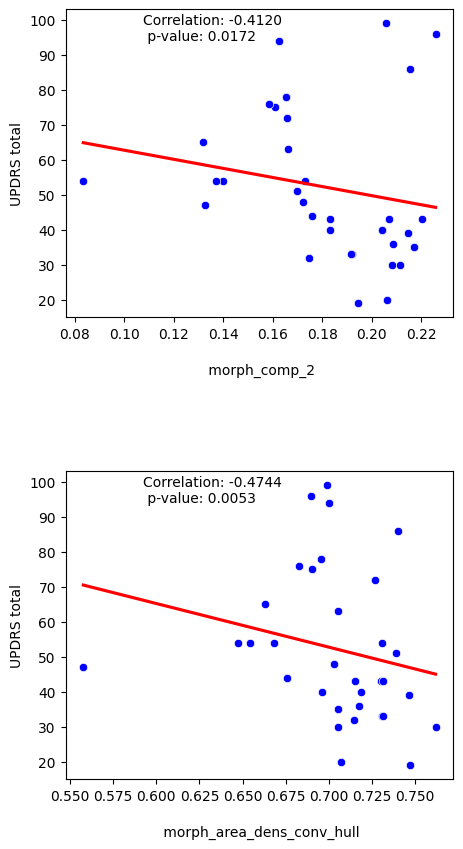

In [199]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))

for i, col in enumerate(UPDRStot_results2['features']):
    ax = axs[i]  
    sns.scatterplot(x=radiomics_PD[col], y=clinical['UPDRS total'], color='b', ax=ax)
    sns.regplot(x=radiomics_PD[col], y=clinical['UPDRS total'], color='r', scatter=False, ax=ax, ci=None)
    corr = '{:.4f}'.format(float(UPDRStot_results2[UPDRStot_results2['features'] == col]['Correlation']))
    pv =  '{:.4f}'.format(float(UPDRStot_results2[UPDRStot_results2['features'] == col]['p_values']))
    ax.annotate( f"Correlation: {corr} \n p-value: {pv}", xy=(0.2, 0.9), xycoords='axes fraction')
    ax.set_xlabel(f'\n {col}')
    ax.set_ylabel('UPDRS total')       

for i in range(len(radiomics_HC.columns), 1*2):
    axs[i // 2][i % 2].axis('off')

plt.subplots_adjust(hspace=0.5, wspace=1)

plt.show()


NMSQ

In [200]:
correlations_NMSQ = []
p_values_NMSQ = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics_PD[feature], clinical['NMSQ'])
    correlations_NMSQ.append(corr)
    p_values_NMSQ.append(p_value)

temp10 = list(zip(radiomics_PD.columns, correlations_NMSQ, p_values_NMSQ))

NMSQ_results = pd.DataFrame(temp10, columns = ['features','Correlation', 'p_values'])
NMSQ_results

,features,Correlation,p_values
0,stat_qcod,0.120730,0.503333
1,ivh_v50,0.347414,0.047594
2,ivh_diff_v25_v75,0.326425,0.063737
3,ivh_diff_i25_i75,0.149636,0.405892
4,morph_comp_2,-0.255901,0.150599
5,morph_com,-0.001007,0.995560
6,morph_pca_maj_axis,0.062128,0.731245
7,morph_pca_elongation,0.102260,0.571208
8,morph_area_dens_aee,-0.105450,0.559194
9,morph_area_dens_conv_hull,-0.153641,0.393296


In [201]:
NMSQ_results = NMSQ_results[NMSQ_results['p_values'] < 0.05]
NMSQ_results

,features,Correlation,p_values
1,ivh_v50,0.347414,0.047594


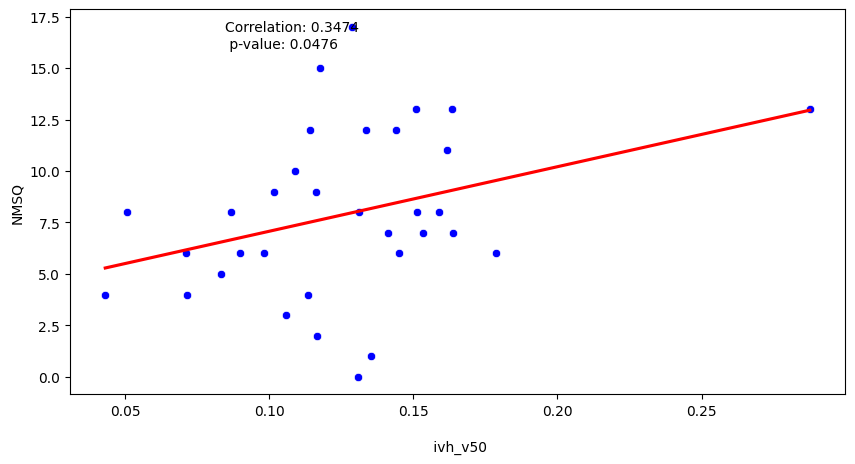

In [202]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, col in enumerate(NMSQ_results['features']):
    sns.scatterplot(x=radiomics_PD[col], y=clinical['NMSQ'], color='b', ax=ax)
    sns.regplot(x=radiomics_PD[col], y=clinical['NMSQ'], color='r', scatter=False, ax=ax, ci=None)
    corr = '{:.4f}'.format(float(NMSQ_results[NMSQ_results['features'] == col]['Correlation']))
    pv =  '{:.4f}'.format(float(NMSQ_results[NMSQ_results['features'] == col]['p_values']))
    ax.annotate( f"Correlation: {corr} \n p-value: {pv}", xy=(0.2, 0.9), xycoords='axes fraction')
    ax.set_xlabel(f'\n {col}')
    ax.set_ylabel('NMSQ')

plt.show()


MMSE

In [203]:
correlations_MMSE = []
p_values_MMSE = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics_PD[feature], clinical['MMSE'])
    correlations_MMSE.append(corr)
    p_values_MMSE.append(p_value)

temp11 = list(zip(radiomics_PD.columns, correlations_MMSE, p_values_MMSE))

MMSE_results = pd.DataFrame(temp11, columns = ['features','Correlation', 'p_values'])
MMSE_results

,features,Correlation,p_values
0,stat_qcod,-0.360696,0.039194
1,ivh_v50,-0.304647,0.084739
2,ivh_diff_v25_v75,-0.010295,0.954657
3,ivh_diff_i25_i75,-0.258459,0.146420
4,morph_comp_2,-0.057765,0.749496
5,morph_com,-0.078735,0.663172
6,morph_pca_maj_axis,0.120105,0.505563
7,morph_pca_elongation,-0.150226,0.404022
8,morph_area_dens_aee,-0.115720,0.521335
9,morph_area_dens_conv_hull,0.032791,0.856248


In [204]:
MMSE_results = MMSE_results[MMSE_results['p_values'] < 0.05]
MMSE_results

,features,Correlation,p_values
0,stat_qcod,-0.360696,0.039194


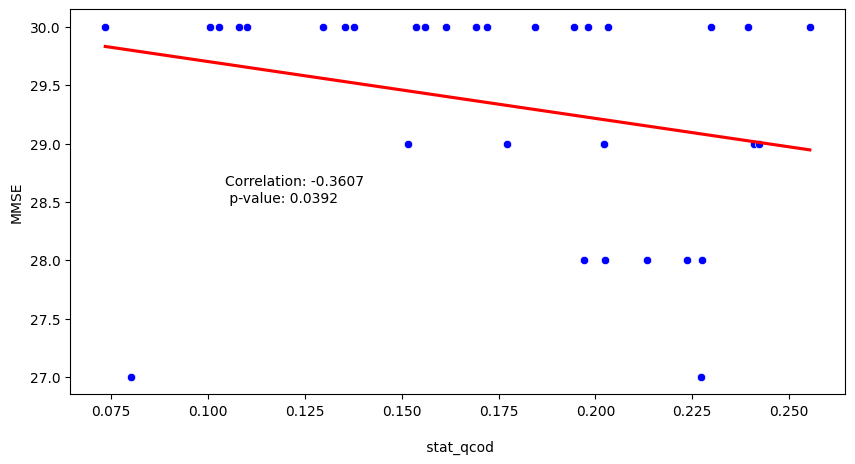

In [205]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, col in enumerate(MMSE_results['features']):
    sns.scatterplot(x=radiomics_PD[col], y=clinical['MMSE'], color='b', ax=ax)
    sns.regplot(x=radiomics_PD[col], y=clinical['MMSE'], color='r', scatter=False, ax=ax, ci=None)
    corr = '{:.4f}'.format(float(MMSE_results[MMSE_results['features'] == col]['Correlation']))
    pv =  '{:.4f}'.format(float(MMSE_results[MMSE_results['features'] == col]['p_values']))
    ax.annotate( f"Correlation: {corr} \n p-value: {pv}", xy=(0.2, 0.5), xycoords='axes fraction')
    ax.set_xlabel(f'\n {col}')
    ax.set_ylabel('MMSE')

plt.show()


MoCA

In [206]:
correlations_MoCA = []
p_values_MoCA = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics_PD[feature], clinical['MoCA'])
    correlations_MoCA.append(corr)
    p_values_MoCA.append(p_value)

temp12 = list(zip(radiomics_PD.columns, correlations_MoCA, p_values_MoCA))

MoCA_results = pd.DataFrame(temp12, columns = ['features','Correlation', 'p_values'])
MoCA_results

,features,Correlation,p_values
0,stat_qcod,0.047759,0.791835
1,ivh_v50,-0.059147,0.743699
2,ivh_diff_v25_v75,-0.086851,0.630807
3,ivh_diff_i25_i75,-0.038588,0.831169
4,morph_comp_2,0.150587,0.402883
5,morph_com,-0.119483,0.507783
6,morph_pca_maj_axis,-0.194947,0.276959
7,morph_pca_elongation,-0.006119,0.973042
8,morph_area_dens_aee,0.350122,0.045773
9,morph_area_dens_conv_hull,0.241516,0.175719


In [207]:
MoCA_results = MoCA_results[MoCA_results['p_values'] < 0.05] 
MoCA_results

,features,Correlation,p_values
8,morph_area_dens_aee,0.350122,0.045773


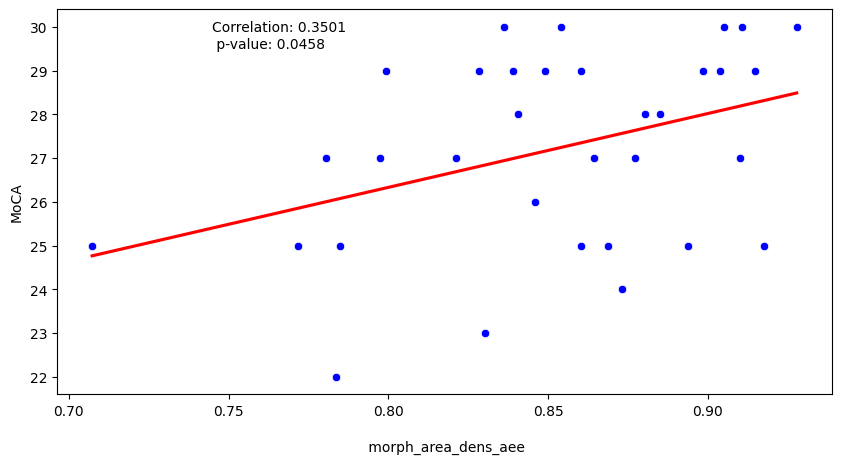

In [208]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, col in enumerate(MoCA_results['features']):
    sns.scatterplot(x=radiomics_PD[col], y=clinical['MoCA'], color='b', ax=ax)
    sns.regplot(x=radiomics_PD[col], y=clinical['MoCA'], color='r', scatter=False, ax=ax, ci=None)
    corr = '{:.4f}'.format(float(MoCA_results[MoCA_results['features'] == col]['Correlation']))
    pv =  '{:.4f}'.format(float(MoCA_results[MoCA_results['features'] == col]['p_values']))
    ax.annotate( f"Correlation: {corr} \n p-value: {pv}", xy=(0.2, 0.9), xycoords='axes fraction')
    ax.set_xlabel(f'\n {col}')
    ax.set_ylabel('MoCA')

plt.show()


LEDD total

In [209]:
correlations_LEDD = []
p_values_LEDD = []
for feature in radiomics.columns[:-1]: 
    corr, p_value = spearmanr(radiomics_PD[feature], clinical['UPDRS I'])
    correlations_LEDD.append(corr)
    p_values_LEDD.append(p_value)

temp13 = list(zip(radiomics_PD.columns, correlations_LEDD, p_values_LEDD))

LEDD_results = pd.DataFrame(temp13, columns = ['features','Correlation', 'p_values'])
LEDD_results

,features,Correlation,p_values
0,stat_qcod,0.086738,0.631250
1,ivh_v50,0.274811,0.121677
2,ivh_diff_v25_v75,0.135896,0.450808
3,ivh_diff_i25_i75,0.166626,0.354037
4,morph_comp_2,-0.107710,0.550755
5,morph_com,-0.045970,0.799474
6,morph_pca_maj_axis,0.060901,0.736362
7,morph_pca_elongation,0.011409,0.949757
8,morph_area_dens_aee,-0.143781,0.424713
9,morph_area_dens_conv_hull,-0.205353,0.251609


In [210]:
LEDD_results = LEDD_results[LEDD_results['p_values'] < 0.05] 
LEDD_results

,features,Correlation,p_values


Comparison of the distribution 

In [244]:
UPDRSI_threshold_min = 10
UPDRSI_threshold_max = 21

low_severity = radiomics_clinical[radiomics_clinical['UPDRS I'] <= UPDRSI_threshold_min] 
moderate_severity = radiomics_clinical[(radiomics_clinical['UPDRS I'] <= UPDRSI_threshold_max) & (radiomics_clinical['UPDRS I'] > UPDRSI_threshold_min)]
high_severity = radiomics_clinical[radiomics_clinical['UPDRS I'] > UPDRSI_threshold_max]  

if high_severity.empty:
  print("There are no high severity data avaiable")

stat = []
p_values = []
for feature in radiomics_PD.columns[:-1]: 
  if high_severity.empty:
    statistic, p_value = kruskal(low_severity[feature],moderate_severity[feature])
  else: 
    statistic, p_value = kruskal(low_severity[feature],high_severity[feature], moderate_severity[feature])
  stat.append(statistic)
  p_values.append(p_value)

temp = list(zip(radiomics_PD.columns, stat, p_values))

results = pd.DataFrame(temp, columns = ['features','Stat', 'p_values'])

There are no high severity data avaiable


In [245]:
results = results[results['p_values'] < 0.05] 
results

,features,Stat,p_values
1,ivh_v50,4.589869,0.032161


In [246]:
UPDRSII_threshold_min = 12
UPDRSII_threshold_max = 29

low_severity = radiomics_clinical[radiomics_clinical['UPDRS II'] <= UPDRSII_threshold_min] 
moderate_severity = radiomics_clinical[(radiomics_clinical['UPDRS II'] <= UPDRSII_threshold_max) & (radiomics_clinical['UPDRS II'] > UPDRSII_threshold_min)]
high_severity = radiomics_clinical[radiomics_clinical['UPDRS II'] > UPDRSII_threshold_max]  

if high_severity.empty:
  print("There are no high severity data avaiable")
  
stat = []
p_values = []
for feature in radiomics_PD.columns[:-1]: 
  if high_severity.empty:
    statistic, p_value = kruskal(low_severity[feature],moderate_severity[feature])
  else: 
    statistic, p_value = kruskal(low_severity[feature],high_severity[feature], moderate_severity[feature])
  stat.append(statistic)
  p_values.append(p_value)

temp = list(zip(radiomics_PD.columns, stat, p_values))

results = pd.DataFrame(temp, columns = ['features','Stat', 'p_values'])

There are no high severity data avaiable


In [247]:
results = results[results['p_values'] < 0.05] 
results

,features,Stat,p_values
9,morph_area_dens_conv_hull,4.906174,0.026761


In [248]:
UPDRSIII_threshold_min = 32
UPDRSIII_threshold_max = 58

low_severity = radiomics_clinical[radiomics_clinical['UPDRS III'] <= UPDRSIII_threshold_min] 
moderate_severity = radiomics_clinical[(radiomics_clinical['UPDRS III'] <= UPDRSIII_threshold_max) & (radiomics_clinical['UPDRS III'] > UPDRSIII_threshold_min)]
high_severity = radiomics_clinical[radiomics_clinical['UPDRS III'] > UPDRSIII_threshold_max]  

if high_severity.empty:
  print("There are no high severity data avaiable")
  
stat = []
p_values = []
for feature in radiomics_PD.columns[:-1]: 
  if high_severity.empty:
    statistic, p_value = kruskal(low_severity[feature],moderate_severity[feature])
  else: 
    statistic, p_value = kruskal(low_severity[feature],high_severity[feature], moderate_severity[feature])
  stat.append(statistic)
  p_values.append(p_value)

temp = list(zip(radiomics_PD.columns, stat, p_values))

results = pd.DataFrame(temp, columns = ['features','Stat', 'p_values'])


There are no high severity data avaiable


In [249]:
results = results[results['p_values'] < 0.05] 
results

,features,Stat,p_values
0,stat_qcod,6.276923,0.012232
3,ivh_diff_i25_i75,4.807376,0.028338
4,morph_comp_2,6.651584,0.009907
7,morph_pca_elongation,6.276923,0.012232
9,morph_area_dens_conv_hull,7.233937,0.007154
12,ih_iqr_fbs_w0.0125,4.730082,0.029639
14,cm_clust_shade_d1_3d_avg_fbs_w0.0125,6.462896,0.011015
16,szm_lzlge_3d_fbs_w0.0125,5.560181,0.018374
17,dzm_sdlge_3d_fbs_w0.0125,4.886878,0.027062


In [250]:
UPDRSIV_threshold_min = 4
UPDRSIV_threshold_max = 12

low_severity = radiomics_clinical[radiomics_clinical['UPDRS IV'] <= UPDRSIV_threshold_min] 
moderate_severity = radiomics_clinical[(radiomics_clinical['UPDRS IV'] <= UPDRSIV_threshold_max) & (radiomics_clinical['UPDRS IV'] > UPDRSIV_threshold_min)]
high_severity = radiomics_clinical[radiomics_clinical['UPDRS IV'] > UPDRSIV_threshold_max]  

stat = []
p_values = []

if high_severity.empty:
  print("There are no high severity data avaiable")

for feature in radiomics_PD.columns[:-1]: 
  if high_severity.empty:
    statistic, p_value = kruskal(low_severity[feature],moderate_severity[feature])
  else: 
    statistic, p_value = kruskal(low_severity[feature],high_severity[feature], moderate_severity[feature])
  stat.append(statistic)
  p_values.append(p_value)

temp = list(zip(radiomics_PD.columns, stat, p_values))

results = pd.DataFrame(temp, columns = ['features','Stat', 'p_values'])


There are no high severity data avaiable


In [251]:
results = results[results['p_values'] < 0.05] 
results

,features,Stat,p_values
3,ivh_diff_i25_i75,4.501946,0.033856
12,ih_iqr_fbs_w0.0125,4.504958,0.033797


# INDIVIDUAL PREDICTION

Are the radiomics features capable to distinguish PD from HC?


In [252]:
X = radiomics.iloc[:,0:-1]
y = radiomics.iloc[:,-1]
X = X.apply(zscore)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [253]:
accuracies_score = []

Logistic regression

In [254]:
model_lr = LogisticRegression(penalty = None)
param_grid = {
    'fit_intercept': [True, False],
    'max_iter' : [10000]
}
grid_lr = GridSearchCV(model_lr, param_grid=param_grid, scoring = "accuracy")
grid_lr.fit(X_train, y_train)

best_model_lr = grid_lr.best_estimator_
cv_scores = cross_val_score(best_model_lr, X_train, y_train, cv=5, scoring="accuracy")
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

print("Cross-Validation Accuracy: {:.4f} +/- {:.4f}".format(mean_cv_score, std_cv_score))

y_pred_lr = best_model_lr.predict(X_test)

print(f"Best parameter configuration for Logistic regression is: {grid_lr.best_params_}")
print(f"Test accuracy score with best parameters is : {accuracy_score(y_test, y_pred_lr)}")

accuracies_score.append(accuracy_score(y_test, y_pred_lr))

Cross-Validation Accuracy: 0.9750 +/- 0.0500
Best parameter configuration for Logistic regression is: {'fit_intercept': True, 'max_iter': 10000}
Test accuracy score with best parameters is : 0.875


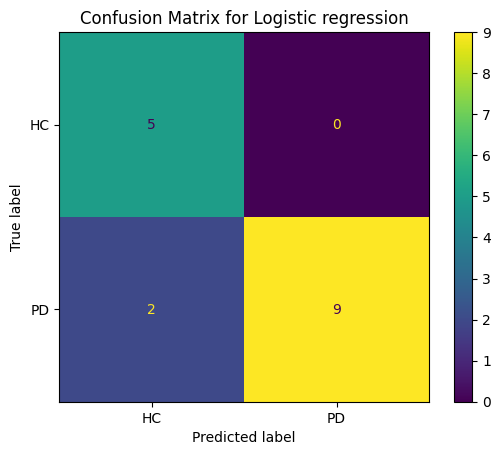

In [255]:
cm = confusion_matrix(y_test, y_pred_lr, labels=best_model_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(("HC", "PD")))
disp.plot()
plt.title("Confusion Matrix for Logistic regression")
plt.show()

Sensitivity for Logistic regression is: 0.8181818181818182
Specificity for Logistic regression is: 1.0


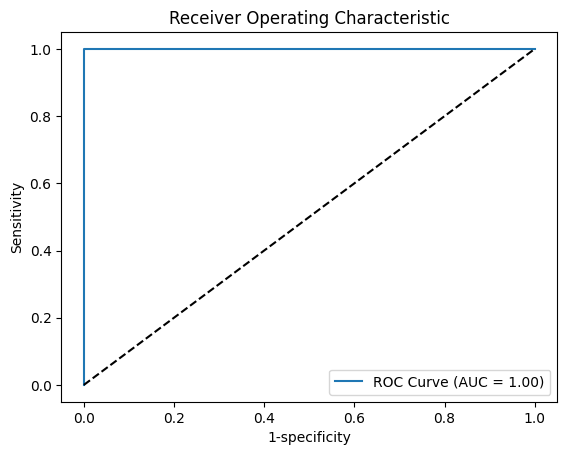

In [257]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity for Logistic regression is: {sensitivity}")
print(f"Specificity for Logistic regression is: {specificity}")

y_pred_prob_lr = best_model_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr)
roc_auc = roc_auc_score(y_test, y_pred_prob_lr)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('1-specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

KNN

In [258]:
knn_model = KNeighborsClassifier()
param_grid = dict(n_neighbors=list((3, 5, 9)))
grid_knn = GridSearchCV(knn_model, param_grid, scoring = "accuracy")
grid_knn.fit(X_train, y_train)

best_model_knn = grid_knn.best_estimator_
cv_scores = cross_val_score(best_model_knn, X_train, y_train, cv=10, scoring="accuracy")
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

print("Cross-Validation Accuracy: {:.4f} +/- {:.4f}".format(mean_cv_score, std_cv_score))

y_pred_knn = best_model_knn.predict(X_test)

print(f"Best parameter configuration for K-NN is: {grid_knn.best_params_}")
print(f"Test accuracy score with best parameters is : {accuracy_score(y_test, y_pred_knn)}")

accuracies_score.append(accuracy_score(y_test, y_pred_knn))

Cross-Validation Accuracy: 1.0000 +/- 0.0000
Best parameter configuration for K-NN is: {'n_neighbors': 3}
Test accuracy score with best parameters is : 0.875


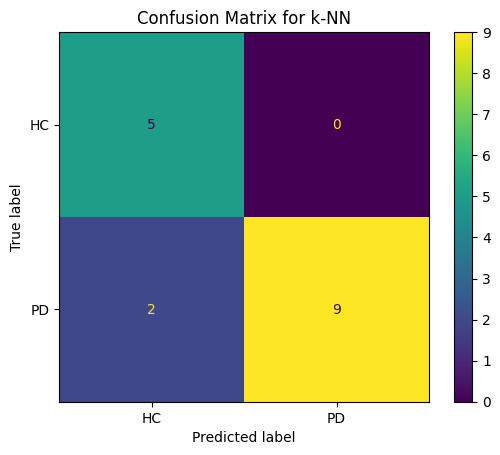

In [259]:
cm = confusion_matrix(y_test, y_pred_knn, labels=best_model_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(("HC", "PD")))
disp.plot()
plt.title("Confusion Matrix for k-NN")
plt.show()

Sensitivity for K-NN is: 0.8181818181818182
Specificity for K-NN is: 1.0


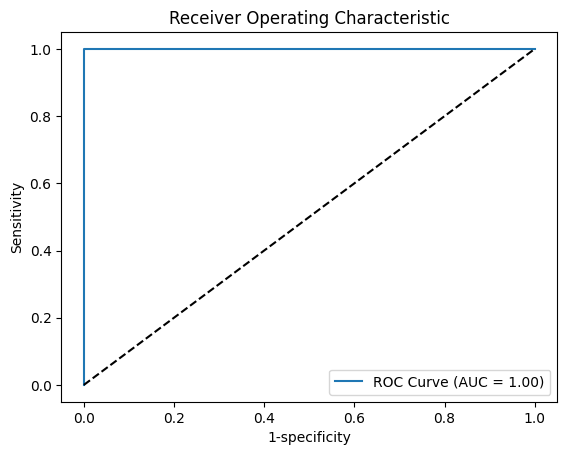

In [260]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_knn).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity for K-NN is: {sensitivity}")
print(f"Specificity for K-NN is: {specificity}")

y_pred_prob_knn = best_model_knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = roc_auc_score(y_test, y_pred_prob_knn)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('1-specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Decision tree

In [261]:
dt_model = DecisionTreeClassifier(random_state= 123)
grid_params = {
    'max_depth' : [None,3,5,10,20,30],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2,4,6,8,10]
}
grid_dt = GridSearchCV(dt_model, grid_params, scoring = "accuracy")
grid_dt.fit(X_train, y_train)

best_model_dt = grid_dt.best_estimator_
cv_scores = cross_val_score(best_model_dt, X_train, y_train, cv=5, scoring="accuracy")
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

print("Cross-Validation Accuracy: {:.4f} +/- {:.4f}".format(mean_cv_score, std_cv_score))

y_pred_dt = best_model_dt.predict(X_test)

print(f"Best parameter configuration for Decision Tree is: {grid_dt.best_params_}")
print(f"Test accuracy score with best parameters is : {accuracy_score(y_test, y_pred_dt)}")


accuracies_score.append(accuracy_score(y_test, y_pred_dt))

Cross-Validation Accuracy: 0.9464 +/- 0.0659
Best parameter configuration for Decision Tree is: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Test accuracy score with best parameters is : 0.875


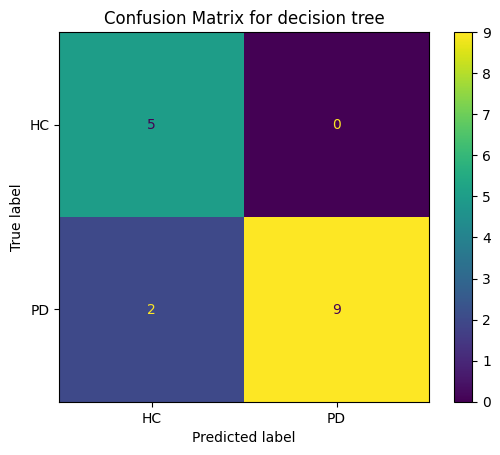

In [262]:
cm = confusion_matrix(y_test, y_pred_dt, labels=best_model_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(("HC", "PD")))
disp.plot()
plt.title("Confusion Matrix for decision tree")
plt.show()

Sensitivity for Decision Tree is: 0.8181818181818182
Specificity for Decision Tree is: 1.0


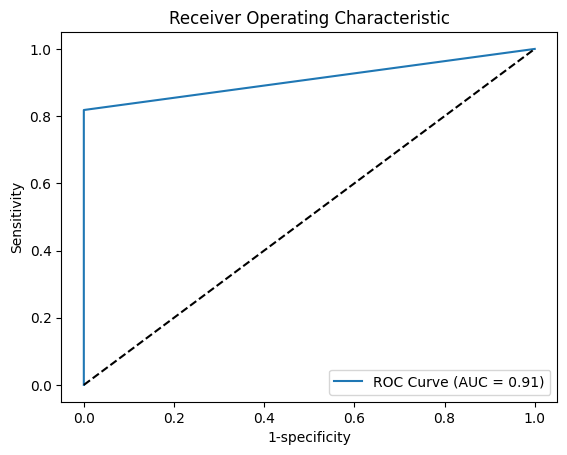

In [263]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_dt).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity for Decision Tree is: {sensitivity}")
print(f"Specificity for Decision Tree is: {specificity}")

y_pred_prob_dt = best_model_dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_dt)
roc_auc = roc_auc_score(y_test, y_pred_prob_dt)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('1-specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Random forest

In [264]:
rf_model = RandomForestClassifier(random_state= 123)
grid_params = {
    'n_estimators': [5, 10, 20],
    'criterion': ['gini','entropy'],
    'max_depth': [None,3, 5, 10]
}
grid_rf = GridSearchCV(rf_model, grid_params, scoring = "accuracy")
grid_rf.fit(X_train, y_train)

best_model_rf = grid_rf.best_estimator_
cv_scores = cross_val_score(best_model_rf, X_train, y_train, cv=10, scoring="accuracy")
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

print("Cross-Validation Accuracy: {:.4f} +/- {:.4f}".format(mean_cv_score, std_cv_score))

y_pred_rt = best_model_rf.predict(X_test)

print(f"Best parameter configuration for Random Forest is: {grid_rf.best_params_}")
print(f"Test accuracy score with best parameters is : {accuracy_score(y_test, y_pred_rt)}")


accuracies_score.append(accuracy_score(y_test, y_pred_rt))

Cross-Validation Accuracy: 0.8583 +/- 0.2358
Best parameter configuration for Random Forest is: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 5}
Test accuracy score with best parameters is : 0.9375


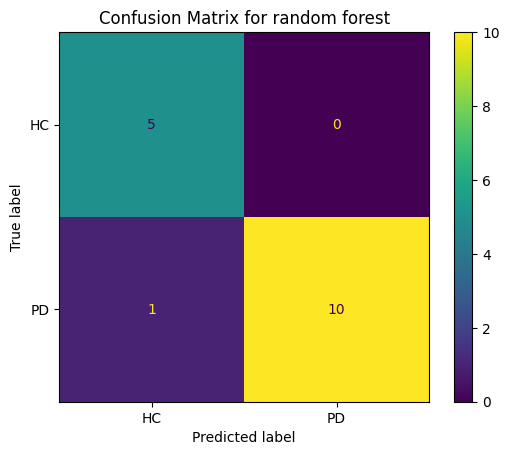

In [265]:
cm = confusion_matrix(y_test, y_pred_rt, labels=best_model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(("HC", "PD")))
disp.plot()
plt.title("Confusion Matrix for random forest")
plt.show()

Sensitivity for Random Forest is: 0.9090909090909091
Specificity for Random Forest is: 1.0


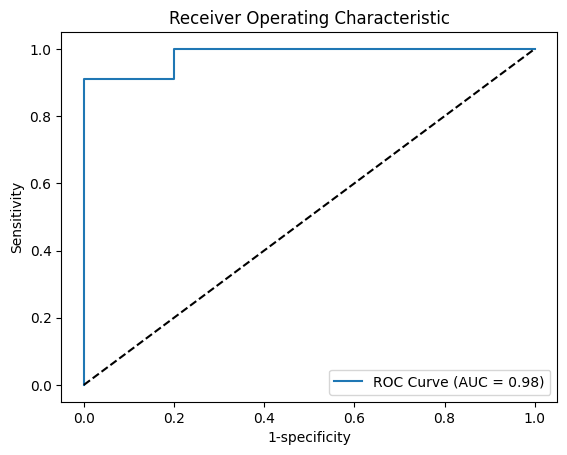

In [266]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rt).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity for Random Forest is: {sensitivity}")
print(f"Specificity for Random Forest is: {specificity}")

y_pred_prob_rt = best_model_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rt)
roc_auc = roc_auc_score(y_test, y_pred_prob_rt)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('1-specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


SVM

In [267]:
svc_model = SVC(random_state= 123, probability=True, shrinking = False)
grid_params = {
    'C': [0.1, 1., 10., 15.],
    'kernel': ['rbf', 'linear']
}
grid_svc = GridSearchCV(svc_model, grid_params, scoring = "accuracy")
grid_svc.fit(X_train, y_train)

best_model_svc = grid_svc.best_estimator_
cv_scores = cross_val_score(best_model_svc, X_train, y_train, cv=10, scoring="accuracy")
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

print("Cross-Validation Accuracy: {:.4f} +/- {:.4f}".format(mean_cv_score, std_cv_score))

y_pred_svc = best_model_svc.predict(X_test)

print(f"Best parameter configuration for SVC is: {grid_svc.best_params_}")
print(f"Test accuracy score with best parameters is : {accuracy_score(y_test, y_pred_svc)}")


accuracies_score.append(accuracy_score(y_test, y_pred_svc))

Cross-Validation Accuracy: 1.0000 +/- 0.0000
Best parameter configuration for SVC is: {'C': 0.1, 'kernel': 'linear'}
Test accuracy score with best parameters is : 0.875


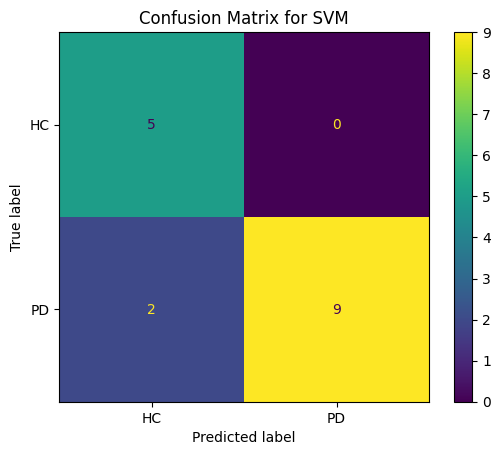

In [268]:
cm = confusion_matrix(y_test, y_pred_svc, labels=best_model_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(("HC", "PD")))
disp.plot()
plt.title("Confusion Matrix for SVM")
plt.show()

Sensitivity for Random Forest is: 0.8181818181818182
Specificity for Random Forest is: 1.0


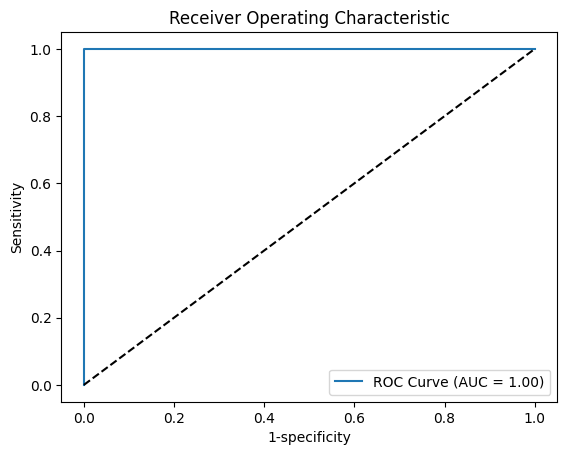

In [269]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svc).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity for Random Forest is: {sensitivity}")
print(f"Specificity for Random Forest is: {specificity}")

y_pred_prob_svc = best_model_svc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_svc)
roc_auc = roc_auc_score(y_test, y_pred_prob_svc)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('1-specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

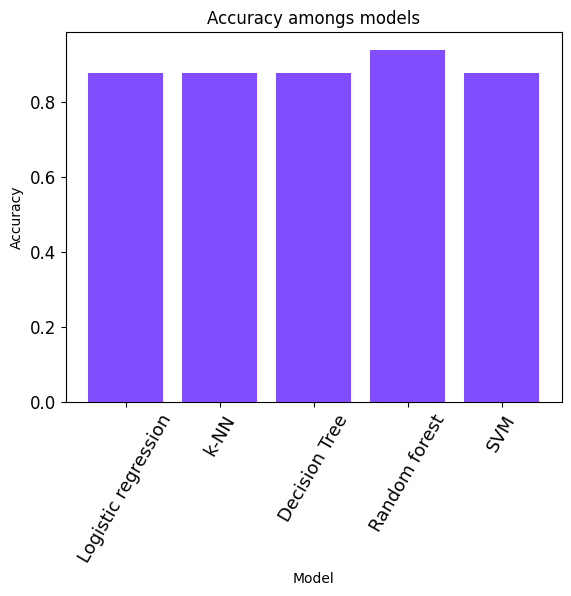

In [270]:
plt.bar(x = ['Logistic regression', 'k-NN', 'Decision Tree', 'Random forest', 'SVM'], height = accuracies_score, color = "#814DFF")
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation = 60, fontsize = 13)
plt.yticks(fontsize = 12)
plt.title('Accuracy amongs models')
plt.show()

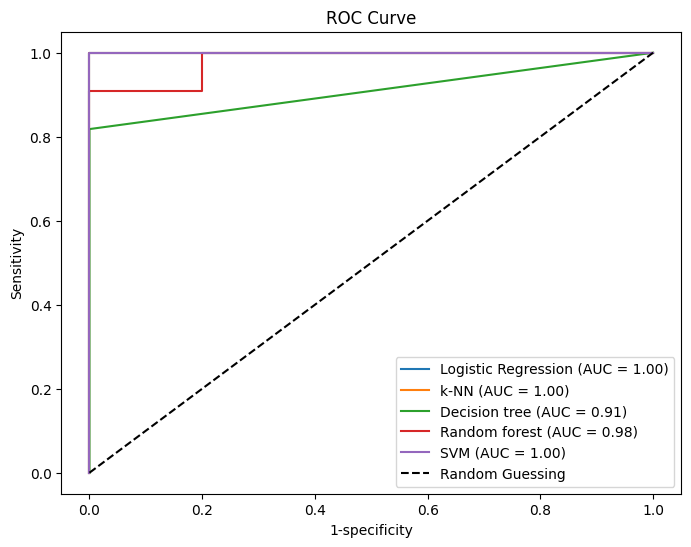

In [271]:
models = [best_model_lr, best_model_knn, best_model_dt, best_model_rf, best_model_svc]  
labels = ['Logistic Regression', 'k-NN', 'Decision tree', 'Random forest', 'SVM']  

plt.figure(figsize=(8, 6))

for model, label in zip(models, labels):
    y_pred = model.predict_proba(X_test)[:, 1]  
    fpr, tpr, _ = roc_curve(y_test, y_pred)  
    auc = roc_auc_score(y_test, y_pred)

    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('1-specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')

plt.legend()
plt.show()
